<a href="https://colab.research.google.com/github/psukphranee/Machine-Learning-Projects/blob/master/Python%20SKLearn/Classification/multilabel_multioutput_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel and Multioutput Classification

## Pull Data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X = mnist.data
y = mnist.target

In [3]:
import numpy as np

y = y.astype(np.uint8)
X_train, y_train, X_test, y_test = X[:60000,:], y[:60000], X[60000:,:], y[60000:]


## Multilabel Classification

We'll train a K-nearest Neighbors algorithm on our training set with two labels: whether it's >= 7 and whether or not it's odd. The algorithm KNN model natively supports multiple labels, but not all models do.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

In [5]:
#filter labels, one for odd and the other \geq 7
y_train_geq_7 = y_train >= 7
y_train_odd = (y_train % 2) == 1

y_train_multi = np.c_[y_train_geq_7, y_train_odd]

In [6]:
knn_clf.fit(X_train, y_train_multi)

KNeighborsClassifier()

Select a random sample. Inspect it and see how what our multilabel model predicts.

In [7]:
#select a random sample and see what our model predicts
rand_index = (np.random.randint(0, 60000))
X_sample = X_train[rand_index]
y_sample = y_train[rand_index]

In [8]:
import matplotlib.pyplot as plt

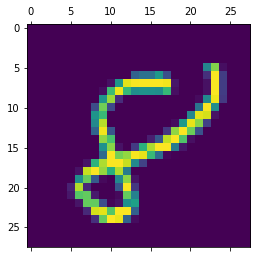

8

In [9]:
plt.matshow(X_sample.reshape(28,28))
plt.show()
display(y_sample)

In [10]:
knn_clf.predict([X_sample])

array([[ True, False]])

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multi, cv=3)
f1_score(y_train_multi, y_train_knn_pred, average='macro')


0.976410265560605

## Multioutput Classification
### Noise Filtering

Multioutput Classification is a generalization of multilabel classification where each label can take on multiple output clases.

In the following code, we create a training set by adding noise to the dataset of digits. We use the original dataset of digits as the training labels. This is an case of multioutput labels where each pixel is a label and it's intensity is the class. In this case the pixel intensity ranges from 0 to 255, so there are 226 classes.

This model acts as a noise filter (explained below). We use the model to filter out noise from the 25 samples. 

In [12]:
X_noise = np.random.randint(0, 100, (len(X_train), 784))

X_train_noise = X_train + X_noise
y_train_noise = X_train

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf.fit(X_train_noise, y_train_noise)

KNeighborsClassifier()

In [40]:
import matplotlib as mpl

#define a function to plot digits
def plot_digits(instances, images_per_row=10, **options):

  size = 28 # 28 x 28 images
  img_per_row = min(len(instances), images_per_row)

  #calculate number of rows needed
  #this is equivalent to ceil(len(instances)/img_per_row) although I'm not sure how.
  #going to read up on this in a discrete math book
  n_rows = (len(instances) + 1) // (img_per_row - 1) 
  print(img_per_row, "rows: ", n_rows)

  #in case the instances are less than number of rows * the images per row, we'll pad them with zeros
  #of 28 x 28 dimension. the rows of padded_instances are images flattened out. 
  n_padding = (n_rows * img_per_row) - len(instances)
  padded_instances = np.concatenate([instances, np.zeros((n_padding, size * size))], axis=0)

  #we perform a reshaping of the padded_instances. each row in padded_instances will fill a 28x28 (size x size)
  #square. there are n_row * img_per_row of these squares. e.g. the element num_grid[0,0] contains a 28x28
  #ndarray of numbers corresponding to the first row of instances
  num_grid = padded_instances.reshape(n_rows, img_per_row, size, size)
  

  #num_grid is a 4D array that needs to be mapped to a 2D array before rendering. 
  #We will have to modify the way the 4D array is indexed, by using the function transpose(), prior to mapping it using reshape().
  #ex) num_grid(0,1,12,18) is the (12,18) pixel of image (0,1)
  #the operation transpose(0,2,1,3) will modify the index so that the first two indices are rows and last two are columns
  #of the image grid and pixels, respectively. For example, the incrementing indices (0,0,0,0) -> (0,0,0,1) -> (0,0,0,2)
  #will sweep across the first row of pixels of images num_grid's first row. 
  num_grid_2D = num_grid.transpose(0,2,1,3).reshape(n_rows * size, img_per_row * size)

  plt.imshow(num_grid_2D, cmap=mpl.cm.binary, **options)
  plt.axis("off")

In [76]:
filtered_samples = knn_clf.predict(X_train_noise[:25])
unfiltered_samples = X_train_noise[:25]

5 rows:  6
5 rows:  6


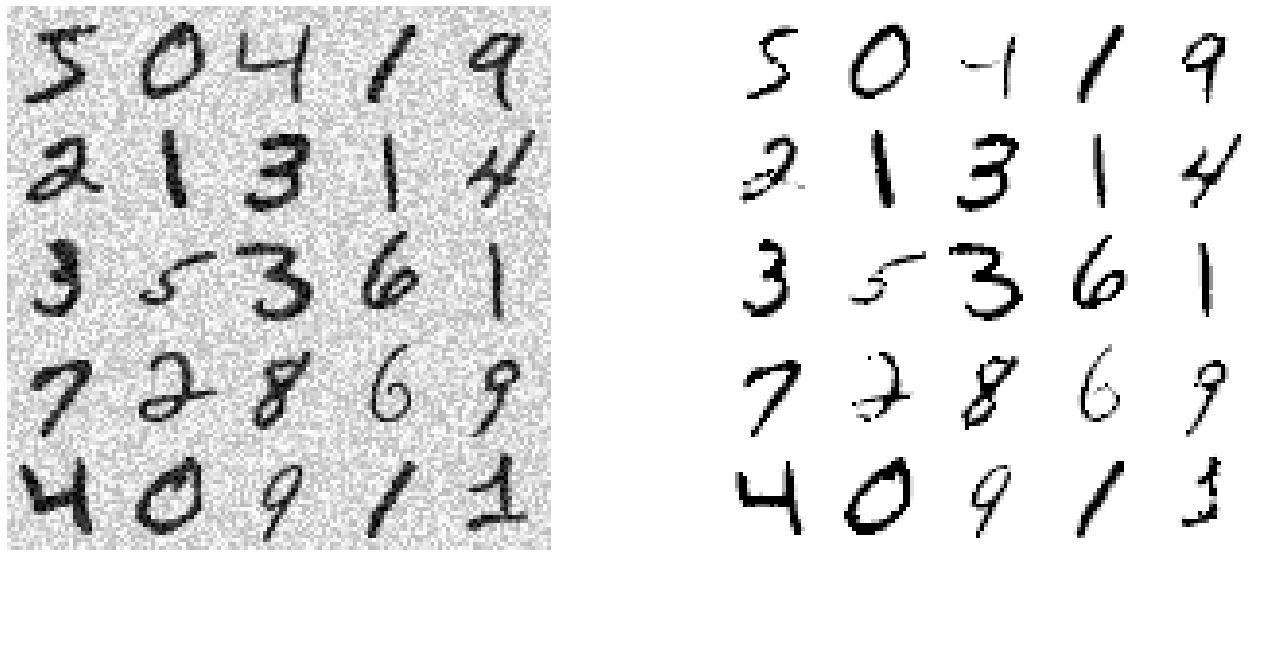

In [102]:
#plot digits
plt.figure(figsize=(36,12))
plt.subplot(131)
plot_digits(unfiltered_samples, images_per_row=5)
plt.subplot(132)
plot_digits(filtered_samples, images_per_row=5)

plt.show()


### How it Works

The KNN classifier determines how many classes there are for each pixel. Look below, there are 784 "Classes Length" corresponding to 784 pixels. Each of those pixels have some number of classes corresponding to pixel intensities found in the label data.

For example, pixel 0 has 1 class, which is of 0 intensity. Every digit in the label data (digits without noise) has a 0 intensity pixel in the uppermost left corner. 

Lets take a look at some arbitrary value below, say 65. This means that for the corresponding pixel position, every instance in the label data (digits without noise) takes on 1 of 65 intensities. 

This particualar KNN model calculuates, by default, 5 nearest neighbors. Consider the instance '4' in row 1 column 3 and pixels of the stem that it's missing. This particular instance is measured to be closest to some samples, $$\{n_{i_1}, n_{i_2}, n_{i_3}, n_{i_4}, n_{i_5}\}.$$
It's reasonable to conclude that the samples above belong to different classes. And that the most occuring class corresponds to low intensity, say 0. 

The neighbors remain the same since they're calculated from the features. However, the classes that each neighbor belongs to is different for each pixel.  

In [103]:
knn_class_lengths = map(len, knn_clf.classes_)
display("Classes Length", len(knn_clf.classes_))
display([x for x in knn_class_lengths])

'Classes length'

784

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 7,
 14,
 19,
 34,
 35,
 51,
 61,
 65,
 62,
 61,
 69,
 51,
 40,
 29,
 22,
 14,
 6,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 8,
 12,
 31,
 58,
 81,
 137,
 178,
 206,
 229,
 238,
 246,
 249,
 249,
 248,
 243,
 230,
 191,
 150,
 97,
 48,
 18,
 5,
 1,
 1,
 1,
 1,
 4,
 8,
 17,
 48,
 84,
 149,
 193,
 236,
 251,
 254,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 253,
 239,
 207,
 121,
 62,
 20,
 3,
 1,
 1,
 2,
 6,
 17,
 56,
 131,
 196,
 239,
 254,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 255,
 255,
 241,
 192,
 94,
 19,
 3,
 1,
 1,
 11,
 48,
 141,
 211,
 250,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 251,
 204,
 85,
 6,
 1,
 3,
 25,
 95,
 206,
 247,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 245,
